In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
labels = pd.read_csv("../Data/labels.csv")

# Explanatory Data Analysis

In [3]:
labels.head()

id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

NOTE: Noticed how the id contains only the image name and no extension(jpg in this scenario)

In [4]:
labels.describe()

id               breed
count                              10222               10222
unique                             10222                 120
top     fff43b07992508bc822f33d8ffd902ae  scottish_deerhound
freq                                   1                 126

In [5]:
labels['breed'].value_counts()

breed
scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
golden_retriever         67
komondor                 67
brabancon_griffon        67
eskimo_dog               66
briard                   66
Name: count, Length: 120, dtype: int64

In [6]:
labels['breed'].value_counts().describe()

count    120.000000
mean      85.183333
std       13.298122
min       66.000000
25%       75.000000
50%       82.000000
75%       91.250000
max      126.000000
Name: count, dtype: float64

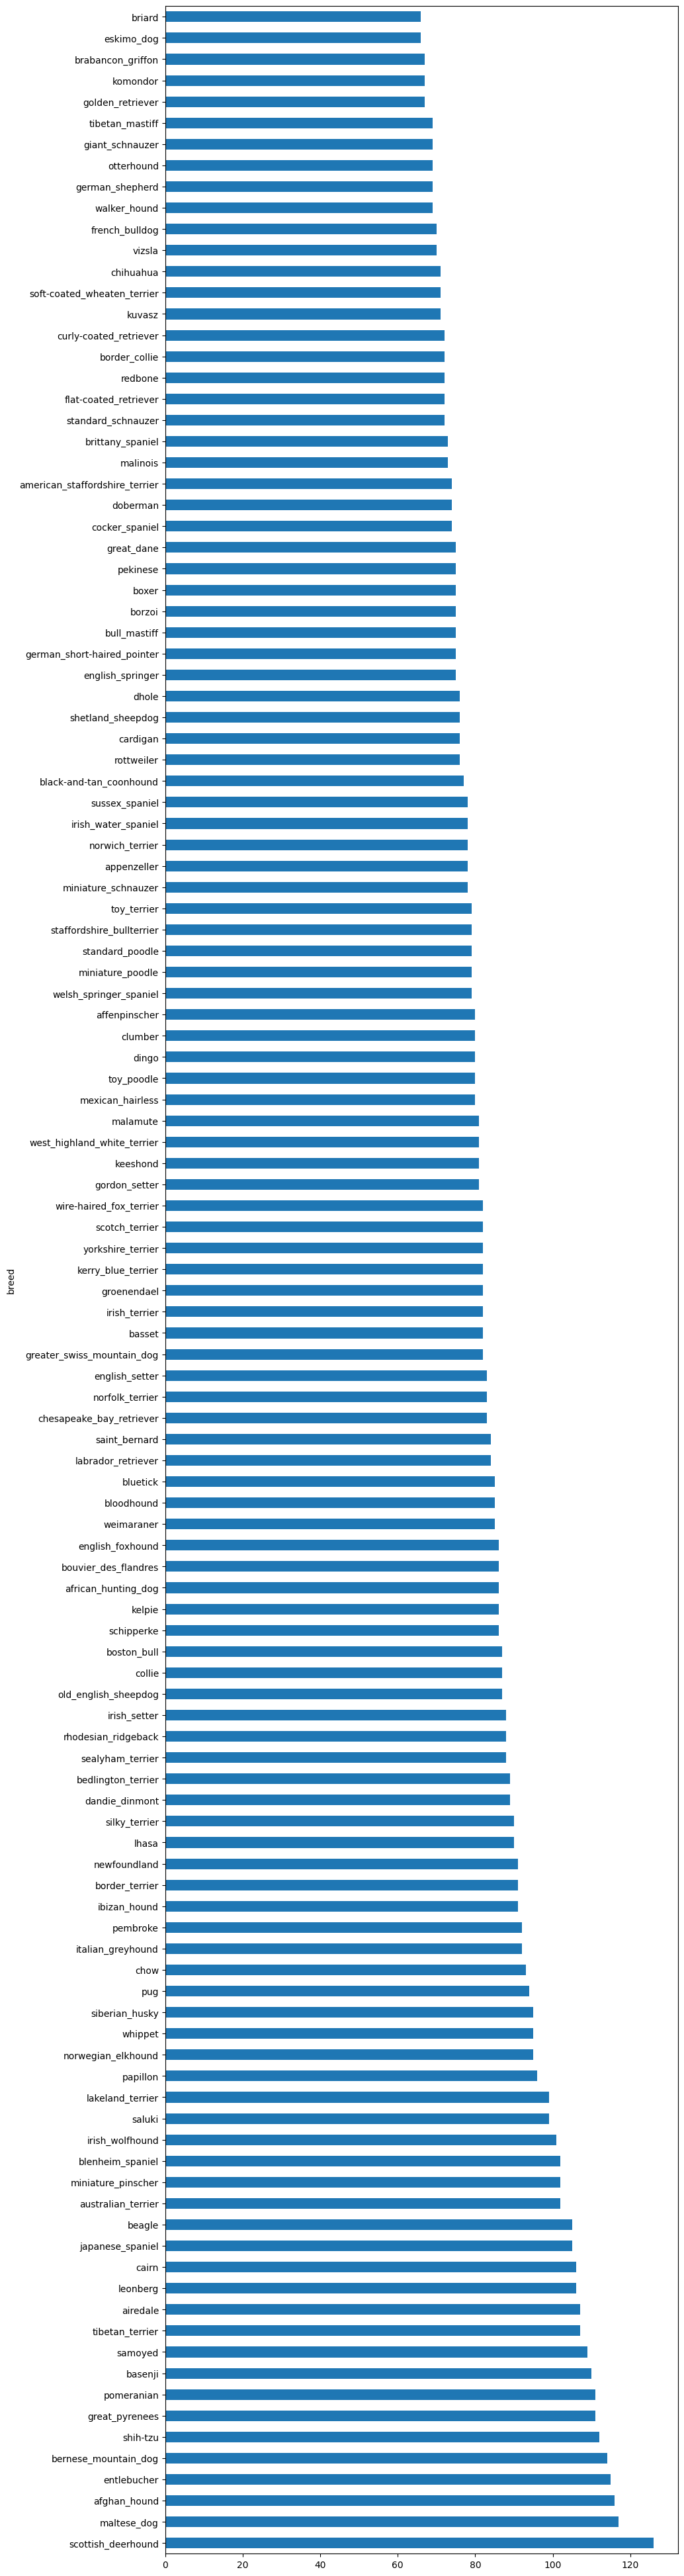

In [7]:
# Check Distribution of breed counts(for inconsistencies)
labels['breed'].value_counts().plot(kind='barh', figsize=(10, 50))
plt.show()

NOTE: There exist a difference range of 60 when it comes to the breed counts

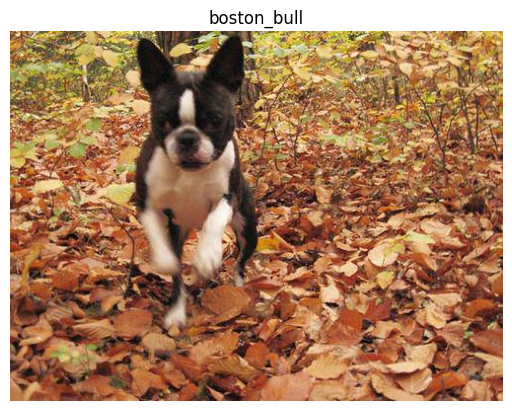

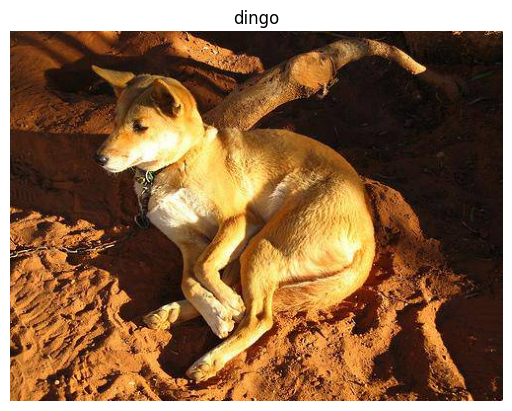

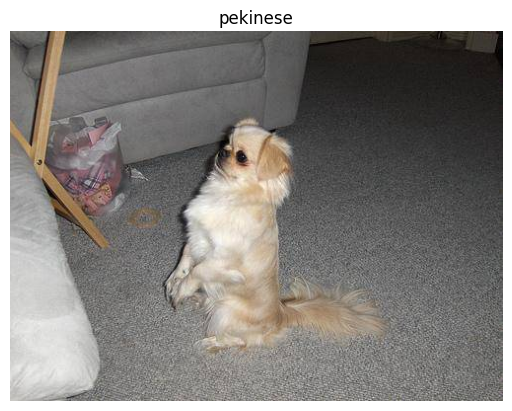

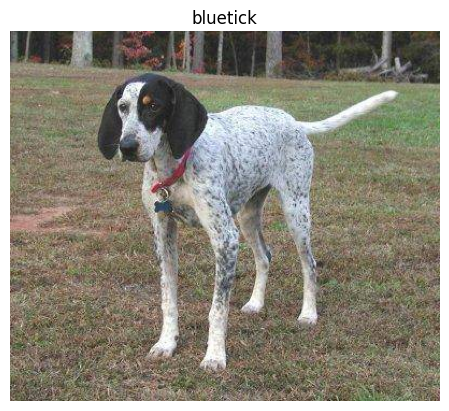

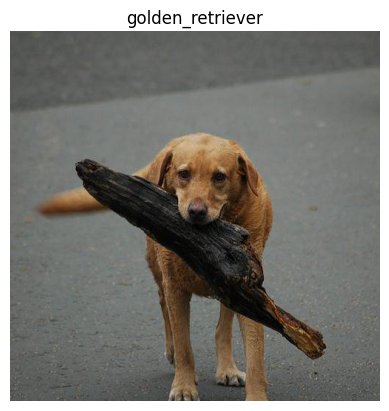

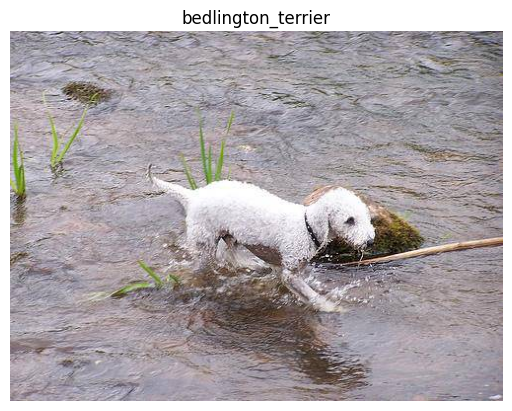

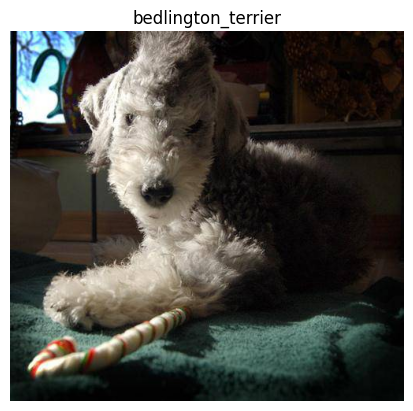

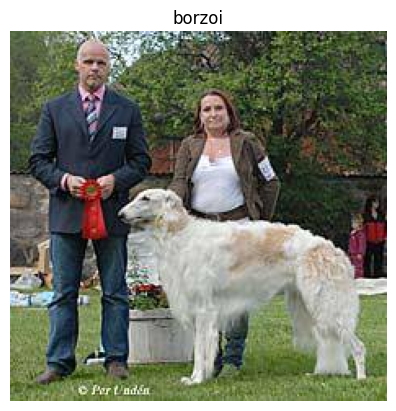

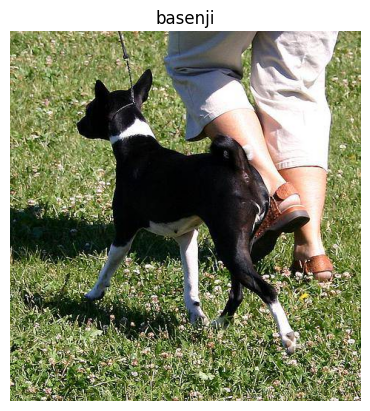

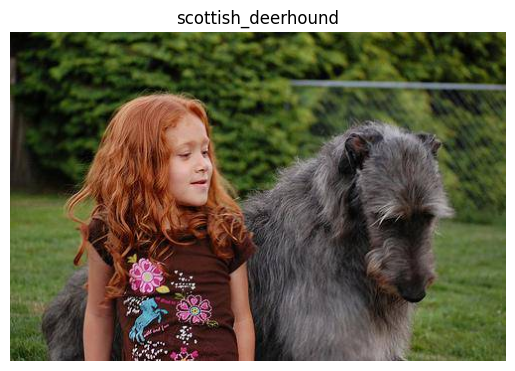

In [8]:
# Visualize first 10 images to identify size mismatch
from PIL import Image
import os
train_dir = '../Data/train/'
for i in range(10):  # Loop through the first 10 images
    sample_image_id = labels.iloc[i]['id']
    img_path = os.path.join(train_dir, sample_image_id + '.jpg')
    img = Image.open(img_path)    
    plt.figure()  # Create a new figure for each image(to find mismatch in sizes)
    plt.imshow(img)
    plt.title(labels.iloc[i]['breed'])
    plt.axis('off')
plt.show()

NOTE: There exists image size mismatch

# Data Preprocess & Augmentation

In [9]:
# Add .jpg extension ONLY if it's not already present
labels['id'] = labels['id'].apply(lambda x: x if x.endswith('.jpg') else x + '.jpg') 

In [15]:
labels.head()

id             breed
0  000bec180eb18c7604dcecc8fe0dba07.jpg       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97.jpg             dingo
2  001cdf01b096e06d78e9e5112d419397.jpg          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d.jpg          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62.jpg  golden_retriever

In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.2 # Good Practice lu
)

train_gen = datagen.flow_from_dataframe(
    labels,
    directory='../Data/train/',
    x_col='id',
    y_col='breed',
    subset='training',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_gen = datagen.flow_from_dataframe(
    labels,
    directory='../Data/train/',
    x_col='id',
    y_col='breed',
    subset='validation',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 8178 validated image filenames belonging to 120 classes.
Found 2044 validated image filenames belonging to 120 classes.


In [18]:
# Compensation for breed class imbalances
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

# extract the training labels array
y_train = train_gen.classes  # integer‑encoded class labels
class_indices = train_gen.class_indices

weights = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(len(class_indices)),
    y=y_train
)
class_weight = dict(enumerate(weights))

# Create CNN Model

## ResNet50 Approach

In [19]:
import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

base = tf.keras.applications.ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)
# freeze backbone
for layer in base.layers:
    layer.trainable = False

x = GlobalAveragePooling2D()(base.output)
x = Dense(512, activation='relu')(x)
out = Dense(len(class_indices), activation='softmax')(x)

model = Model(base.input, out)
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 22s 0us/step


In [20]:
model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    class_weight=class_weight
)

D:\WorkShit\DogBreed-CNN-Classifer\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 389s 1s/step - accuracy: 0.0066 - loss: 4.8679 - val_accuracy: 0.0088 - val_loss: 4.7876
Epoch 2/10
 21/256 ━━━━━━━━━━━━━━━━━━━━ 4:50 1s/step - accuracy: 0.0064 - loss: 4.7704

KeyboardInterrupt: 

## VGG16 Approach

In [31]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
num_classes= 120 # since 120 unique breeds
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
base_model.trainable = False  # Freeze the base model to keep pre-trained weights

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax') 
])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_8           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 120)                 │          61,560 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,038,904 (57.37 MB)

 Trainable params: 324,216 (1.24 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [32]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [36]:
print(" train samples:", train_gen.samples)
print("val samples:", val_gen.samples)
print(" train batches:", len(train_gen))
print(" val batches:", len(val_gen))

 train samples: 8178
val samples: 2044
 train batches: 256
 val batches: 64


In [37]:
EPOCHS = 20

history = model.fit(
    train_gen,
    steps_per_epoch=train_gen.samples // BATCH_SIZE,
    validation_data=val_gen,
    validation_steps=val_gen.samples // BATCH_SIZE,
    epochs=EPOCHS
)

Epoch 1/20
255/255 ━━━━━━━━━━━━━━━━━━━━ 1084s 4s/step - accuracy: 0.0136 - loss: 4.8447 - val_accuracy: 0.0263 - val_loss: 4.6895
Epoch 2/20
  1/255 ━━━━━━━━━━━━━━━━━━━━ 14:32 3s/step - accuracy: 0.0625 - loss: 4.6041

D:\WorkShit\DogBreed-CNN-Classifer\venv\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


KeyboardInterrupt: 